 MERGE SUCCESSFUL — Rows: 211224



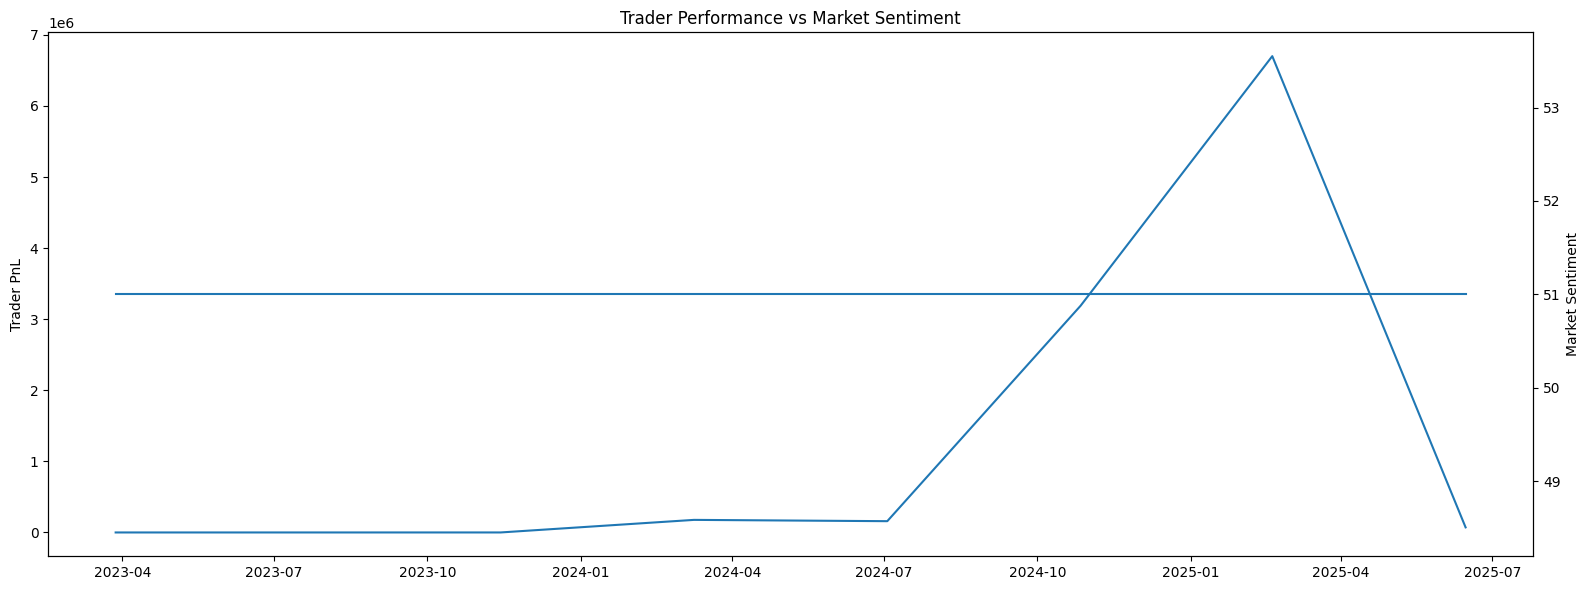

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------
# LOAD FILES (YOUR EXACT NAMES)
# ------------------------------------------------
sentiment = pd.read_csv("data/sentiment.csv")
traders = pd.read_csv("data/trader_data.csv")


# ------------------------------------------------
# FIX TIMESTAMPS (MOST IMPORTANT STEP)
# ------------------------------------------------
sentiment['timestamp'] = pd.to_datetime(
    sentiment['timestamp'],
    unit='ms',
    errors='coerce'
)

traders['Timestamp'] = pd.to_datetime(
    traders['Timestamp'],
    unit='ms',
    errors='coerce'
)

# Create common date column
sentiment['date'] = sentiment['timestamp'].dt.floor('D')
traders['date'] = traders['Timestamp'].dt.floor('D')

# Remove bad rows
sentiment.dropna(subset=['date'], inplace=True)
traders.dropna(subset=['date'], inplace=True)

# ------------------------------------------------
# REMOVE DUPLICATES (prevents merge crash)
# ------------------------------------------------
sentiment = sentiment.sort_values('date').drop_duplicates('date')

traders = traders.sort_values('date')

# ------------------------------------------------
# PERFECT MERGE
# ------------------------------------------------
merged = pd.merge_asof(
    traders,
    sentiment[['date','value','classification']],
    on='date',
    direction='backward'
)

print(f" MERGE SUCCESSFUL — Rows: {len(merged)}\n")

# Fill missing sentiment safely
merged['value'] = merged['value'].ffill()

# ------------------------------------------------
# DAILY ANALYSIS
# ------------------------------------------------
daily = merged.groupby('date').agg({
    'Closed PnL':'sum',
    'value':'mean'
}).dropna()


# ------------------------------------------------
# PROFESSIONAL GRAPH (Dual Axis)
# ------------------------------------------------
fig, ax1 = plt.subplots(figsize=(16,6))

ax1.plot(daily.index, daily['Closed PnL'])
ax1.set_ylabel('Trader PnL')

ax2 = ax1.twinx()
ax2.plot(daily.index, daily['value'])
ax2.set_ylabel('Market Sentiment')

plt.title("Trader Performance vs Market Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


